# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Изучение данных

In [3]:
data = pd.read_csv('real_estate_data.csv', sep = '\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<function matplotlib.pyplot.show(close=None, block=None)>

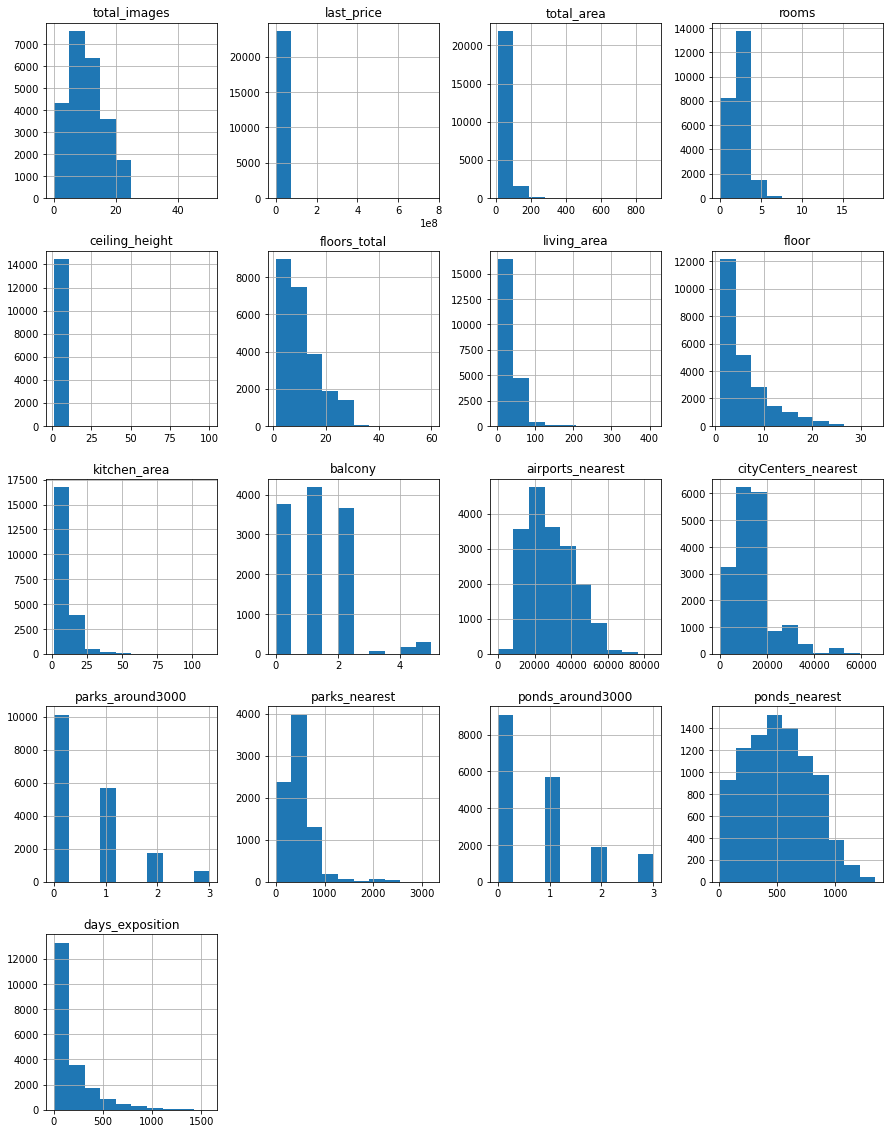

In [5]:
data.hist(figsize=(15, 20))
plt.show

### Предобработка данных

#### Пропущенные значения

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [8]:
display(data['living_area'].corr(other = data['total_area']))
data['living_area'].corr(other = data['rooms'])

0.9395373338721495

0.8459774567888595

In [9]:
data['living_area'] = data['living_area'].fillna(data.groupby('total_area')['living_area'].transform('median'))
#так как заполнились не все значения, потому что нужная полная площадь отсутсвует, воспользуемся еще количеством комнат
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))

In [10]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [11]:
data['is_apartment'] = data['is_apartment'].fillna(False) #Скорее всего данные не были внесены, так как помещение не является апартаментами

In [12]:
data['balcony'] = data['balcony'].fillna(0) #отсутствие балкона
data['parks_around3000'] = data['parks_around3000'].fillna(0) #отсутствие парков в округе
data['ponds_around3000'] = data['ponds_around3000'].fillna(0) #отсутствие водоемов в округе
data['kitchen_area'] = data['kitchen_area'].fillna(0) #предположим, что кухни в помещении нет, поэтому площадь ее 0

In [13]:
data['floors_total'] = data['floors_total'].fillna(-1) 
data['airports_nearest'] = data['airports_nearest'].fillna(-1) 
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1) 
data['parks_nearest'] = data['parks_nearest'].fillna(-1) 
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1) 
data['days_exposition'] = data['days_exposition'].fillna(-1) 

ceiling_height - высота потолков. Нельзя заполнить достоверно, сильно исказятся данные. Еще есть сильные выбросы, для начала нужно исправить их, потом еще можно подумать о заполненнии пропусков медианой. Не указал пользователь, технический сбой

floors_total - количество этажей в доме. Нельзя заполнить средним значением или этажем на котором расположена квартира, так как это сильно искозит данные. Пропуски могли возникнуть, если их не заполнил пользователь или из-за потере при форматировании данных. Чтобы не исказить данные, заполним пропуски -1

locality_name - название населенного пункта. Нельзя заполнить. Не внесены данные пользователем или технический сбой.

airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest - расстояние до аэропорта, центра города, парка, водоема. Нельзя заполнить достоверно. Техническая ошибка, так как данные должны заполняться автоматически. Пользователь не указал данные необходимые для автоматического заполнения. Заполним данные значения -1

days_exposition - кол-во дней размещения объявления. Технические потери, нельзя заполнить достоверно. Заполним пропуски -1

In [14]:
#Проверка данных
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          9195
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name             49
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition            0
dtype: int64

#### Типы данных

In [15]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [16]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,-1.0
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,-1.0,0.0,-1.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,95.0,9,False,...,0.0,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [17]:
#Узнаем дробную часть в числе
def after_dot(number):
    count = 0
    if number % 1 > 0:
        count +=1
    return count

In [18]:
#Изменим данные типа float на int, где дробная часть равна 0
for column in data.columns:
    if data[column].dtypes == float:
        if data[column].apply(after_dot).sum() == 0:
            data[column] = data[column].astype('int')

In [19]:
#проверим типы данных
data.dtypes

total_images              int64
last_price                int32
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total              int32
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                   int32
locality_name            object
airports_nearest          int32
cityCenters_nearest       int32
parks_around3000          int32
parks_nearest             int32
ponds_around3000          int32
ponds_nearest             int32
days_exposition         float64
dtype: object

Последний столбец не изменился, хотя в нем записаны дни, проверим

In [20]:
def after_dot_examination(number):
    count = 0
    if number % 1 > 0:
        count +=1
        print(number)
data['days_exposition'].apply(after_dot_examination)

182.00000000000003
757.0000000000001
23.000000000000004
382.00000000000006
45.00000000000001
3.0000000000000004
45.00000000000001
717.0000000000001
359.00000000000006
704.0000000000001
44.00000000000001
702.0000000000001


48.00000000000001
181.00000000000003
6.000000000000001
45.00000000000001
721.0000000000001
45.00000000000001
193.00000000000003
23.000000000000004
45.00000000000001


0        None
1        None
2        None
3        None
4        None
         ... 
23694    None
23695    None
23696    None
23697    None
23698    None
Name: days_exposition, Length: 23699, dtype: object

Даже если в дробной части содержатся доли дня они незначительны, можем округлить

In [21]:
data['days_exposition'] = data['days_exposition'].astype('int')

In [22]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y.%m.%dT%H:%M:%S') #столбец с датой

In [23]:
#проверим типы данных
data.dtypes

total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest                 int32
cityCenters_nearest              int32
parks_around3000                 int32
parks_nearest                    int32
ponds_around3000                 int32
ponds_nearest                    int32
days_exposition                  int32
dtype: object

#### Уникальные значения

In [24]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'].sort_values().unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'городской поселок большая ижора',
       'городской поселок янино-1', 'городской посёлок будогощь',
       'городской посёлок виллози', 'городской посёлок лесогорский',
       'городской посёлок мга', 'городской посёлок назия',
       'городской посёлок новоселье', 'городской посёлок павлово',
       'городской посёлок рощино', 'городской посёлок свирьстрой',
       'городской посёлок советский', 'городской посёлок фёдоровское',
       'городской посёлок янино-1', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка

In [25]:
len(data['locality_name'].sort_values().unique())

365

In [26]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции','поселок станции')

In [27]:
len(data['locality_name'].sort_values().unique())

322

поселок городского типа павлово - село павлово

поселок гарболово - деревня гарболово

поселок зимитицы - деревня зимитицы

деревня кудрово - кудрово

поселок рабитицы - деревня рабитицы

поселок городского типа фёдоровское - деревня фёдоровское

поселок щеглово - деревня щеглово

поселок лесное - коттеджный поселок лесное

поселок любань - любань

поселок мурино - мурино

село никольское - никольское

поселок городского типа рябово - поселок рябово

поселок станции громово - поселок громово

поселок калитино - деревня калитино

In [28]:
data['locality_name'] = data['locality_name'].replace([
    'поселок городского типа павлово', 'деревня гарболово', 'деревня зимитицы', 'деревня кудрово', 'деревня рабитицы', 
     'деревня фёдоровское', 'деревня щеглово', 'коттеджный поселок лесное', 'поселок любань', 'поселок мурино', 
     'село никольское', 'поселок городского типа рябово', 'поселок станции громово', 'деревня калитино'],[
    'село павлово', 'поселок гарболово', 'поселок зимитицы', 'кудрово', 'поселок рабитицы','деревня фёдоровское',
    'поселок щеглово', 'поселок лесное', 'любань', 'мурино', 'никольское', 'поселок рябово', 'поселок громово', 'поселок калитино']
)

In [29]:
len(data['locality_name'].sort_values().unique())

309

#### Аномалии

In [30]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.631461,34.494099,5.892358,9.553814,0.591080,22060.051648,10886.194017,0.469049,166.656399,0.590911,198.498544,156.474619
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.622500,21.881363,4.885249,6.420973,0.959298,16455.589811,9634.876850,0.748534,307.069717,0.883999,305.590550,213.645563
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,6.300000,0.000000,10196.500000,2242.000000,0.000000,-1.000000,0.000000,-1.000000,22.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,21869.000000,11247.000000,0.000000,-1.000000,0.000000,-1.000000,74.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,11.440000,1.000000,34327.000000,15248.500000,1.000000,301.000000,1.000000,389.000000,199.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


(80000000.0, 1000000000.0)

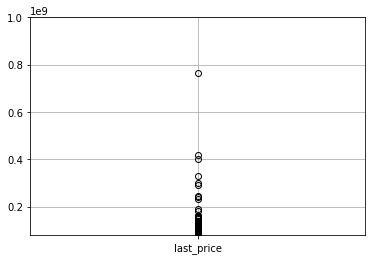

In [31]:
data.boxplot('last_price')
plt.ylim(80000000, 1000000000)

In [32]:
data = data.query('last_price < 80000000')

(200.0, 1000.0)

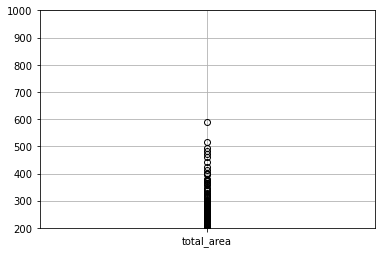

In [33]:
data.boxplot('total_area')
plt.ylim(200, 1000)

In [34]:
data = data.query('total_area < 400')

In [35]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23628.000000,2.362800e+04,23628.000000,23628.000000,14456.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000,23628.000000
mean,9.847765,6.155467e+06,59.526210,2.061368,2.768939,10.641781,34.088188,5.893178,9.482831,0.591629,22049.888353,10905.242340,0.466015,166.212460,0.587481,198.392754,156.255756
std,5.677189,5.839946e+06,31.364259,1.060274,1.261771,6.626272,20.023571,4.887824,6.133966,0.959250,16473.928303,9641.527555,0.745231,306.868588,0.880755,305.827106,213.416938
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,-1.000000,2.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.600000,2.000000,6.300000,0.000000,10142.000000,2244.250000,0.000000,-1.000000,0.000000,-1.000000,22.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,21844.000000,11275.000000,0.000000,-1.000000,0.000000,-1.000000,74.000000
75%,14.000000,6.750000e+06,69.300000,3.000000,2.800000,16.000000,42.200000,8.000000,11.400000,1.000000,34401.750000,15261.000000,1.000000,300.000000,1.000000,389.000000,198.000000
max,50.000000,7.933900e+07,399.000000,19.000000,100.000000,60.000000,264.500000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [36]:
data['ceiling_height'] = data[data['ceiling_height'] >= 10]['ceiling_height']/10 

In [37]:
data.loc[data['floors_total'] > 37, 'floors_total'] = -1 #В Санкт-Петербурге нет домов выше 37 этажей

<AxesSubplot:>

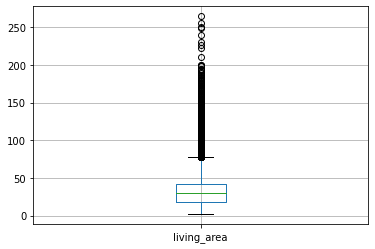

In [38]:
data.boxplot('living_area')
#plt.ylim(100, 1000)

In [39]:
data = data.query('living_area < 200')

Остальные выбросы не очевидны, вполне возмоно, что данные достоверны

#### Явные дубликаты

In [40]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют

#### Вывод:
- Заполнены пропуски в данных
- Исправлены типы данных
- Найдены и исправлены явные и неявные дубликаты
- Данные проверены на аномальные значения и исправлены
- Данные готовы к дальнейшиму анализу

### Добавление в таблицу новых столбцов

#### Цена квадратного метра

In [41]:
def meters(row):
    last_price = row['last_price']
    total_area = row['total_area']
    return last_price/total_area

In [42]:
data['price_one_square_meter'] = data.apply(meters, axis=1)

#### День недели публикации

In [43]:
data['weekday'] = data['first_day_exposition'].dt.weekday

#### Месяц публикации

In [44]:
data['month'] = data['first_day_exposition'].dt.month

#### Год публикации

In [45]:
data['years'] = data['first_day_exposition'].dt.year

#### Тип этажа

In [46]:
def floors(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

In [47]:
data['floors_type'] = data.apply(floors, axis=1)

#### Расстояние до центра в км

In [48]:
def nearest(metrs):
    return int(metrs/1000)

In [49]:
data['city_centers_nearest_km'] = data['cityCenters_nearest'].apply(nearest)

In [50]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,weekday,month,years,floors_type,city_centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,NaN,16,51.0,8,False,...,482,2,755,-1,120370.370370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,-1,0,-1,81,82920.792079,1,12,2018,первый,18
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,90,2,574,558,92785.714286,3,8,2015,другой,13
3,0,64900000,159.0,2015-07-24,3,NaN,14,95.0,9,False,...,84,3,234,424,408176.100629,4,7,2015,другой,6
4,2,10000000,100.0,2018-06-19,2,NaN,14,32.0,13,False,...,112,1,48,121,100000.000000,1,6,2018,другой,8


### Исследовательский анализ данных

#### Анализ данных

##### Общая площадь

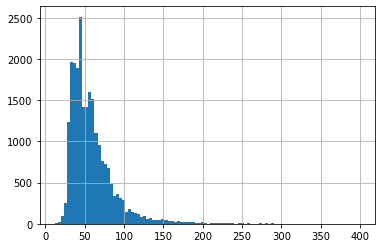

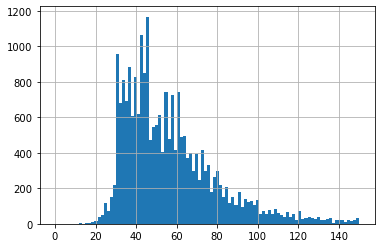

In [51]:
data['total_area'].hist(bins=100)
plt.show()
data['total_area'].hist(bins=100, range=(0,150))
plt.show()

Общая площадь в основном колеблется от 30 до 150 квадратных метров. Распределение похоже на Пуассона

##### Жилая площадь

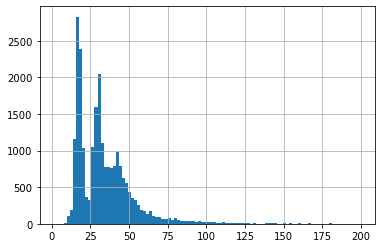

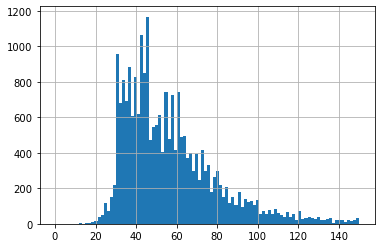

In [52]:
data['living_area'].hist(bins=100)
plt.show()
data['total_area'].hist(bins=100, range=(0,150))
plt.show()

В жилой площади видно, что пик приходится на 45 метров, однако помещений с жилой площадью 50 метров значительно меньше 

##### Площадь кухни

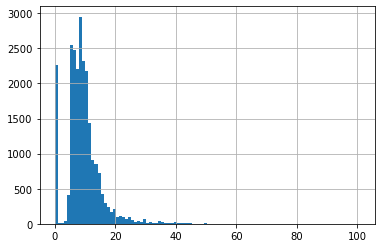

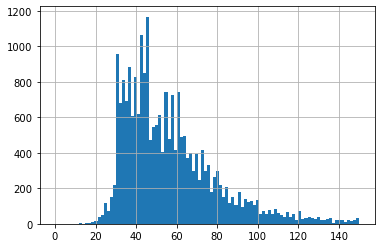

In [53]:
data['kitchen_area'].hist(bins=100)
plt.show()
data['total_area'].hist(bins=100, range=(0,150))
plt.show()

Видно значительно много помещений без кухни (0 квадратных метров) или без данных о кухне. Остальные данные похожи на распределение Пуассона. Заметны выбросы при площади болше 60 метров. Пик приходится на кухни в 45 квалратных метров

##### Цена объекта

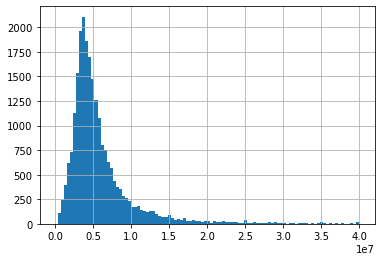

In [54]:
data['last_price'].hist(bins=100, range=(0, 40000000))
plt.show()

Большенство помещение стоят в районе 5000000. 

##### Количество комнат

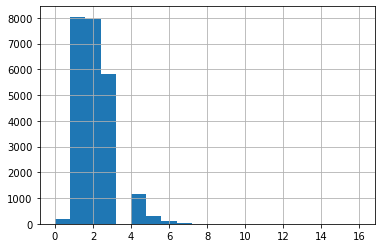

In [55]:
data['rooms'].hist(bins=20)
plt.show()

В основном в помещениях от 1 до 6 комнат, так же есть незначительная доля помещений с количеством комнат более 10

##### Высота потолков

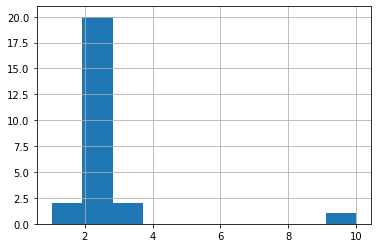

In [56]:
data['ceiling_height'].hist(bins=10)
plt.show()

Высота потолков колеблется от 1 до 3 метров, есть одни выброс с высотой потолка 10 м (в первоначальных данных это было 100м, возможно данные указали в см, то есть это 1 м)

##### Этаж квартиры

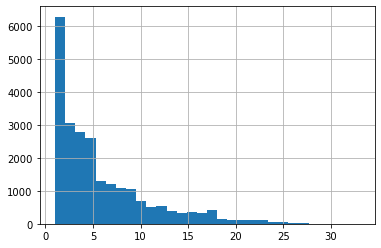

In [57]:
data['floor'].hist(bins=30)
plt.show()

График этажей квартиры похож на распределение Пуассона. Колеблются этажи от 1 до 30

##### Тип этажа квартиры

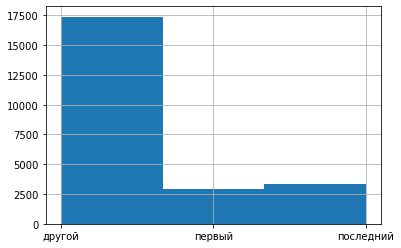

In [58]:
data['floors_type'].hist(bins=3)
plt.show()

Большинство квартир находятся не на первом и не на последнем этажах.

##### Общее количество этажей в доме

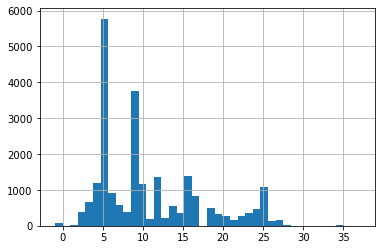

In [59]:
data['floors_total'].hist(bins=40)
plt.show()

Данные реалистичны, есть несколько домов с неизвестной этажностью

##### Растояние до центра города

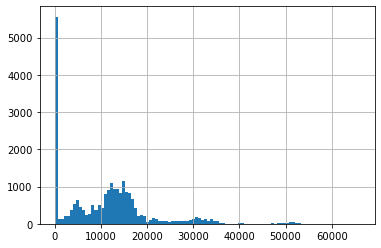

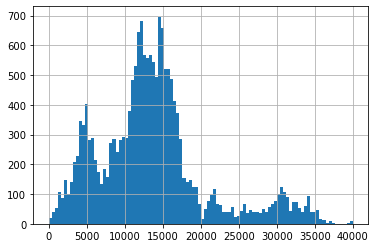

In [60]:
data['cityCenters_nearest'].hist(bins=100)
plt.show()
data['cityCenters_nearest'].hist(bins=100, range=(0, 40000))
plt.show()

Очень много помещений о которых неизвестно расстояние до центра. В основном помещения находятся на расстояние от 10 до 20 км от центра

##### Растояние до аэропорта

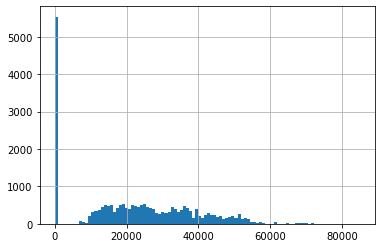

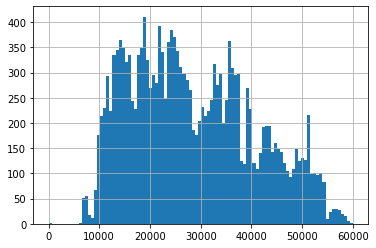

In [61]:
data['airports_nearest'].hist(bins=100)
plt.show()
data['airports_nearest'].hist(bins=100, range=(0, 60000))
plt.show()

Очень много помещений о которых неизвестно расстояние до аэропорта. В основном помещения находятся на расстояние от 10 до 60 км от центра

##### Расстояние до ближайшего парка

<AxesSubplot:>

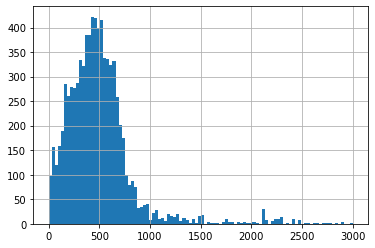

In [62]:
data['parks_nearest'].hist(bins=100, range=(0,3000))

Очень много помещений о которых неизвестно расстояние до ближайшего парка.

##### День и месяц публикации объявления

<AxesSubplot:>

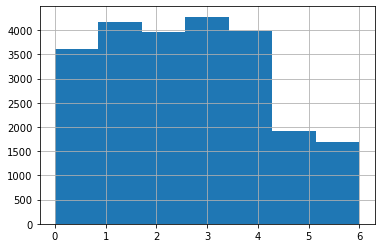

In [63]:
data['weekday'].hist(bins=7)

В выходные объявлений выкладывается меньше, чем в будние дни

<AxesSubplot:>

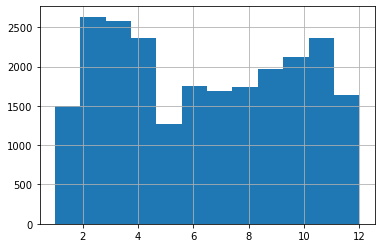

In [64]:
data['month'].hist(bins=12)

Меньше всего объявлений выкладывается в январе и в мая, больше всего в феврале и марте.

Сводка выводов:
- Данные выглядят правдопадобно, за исключением некоторых выбросов
- Много графиков похожи на распредеоение Пуассона
- Много пропусков в столбцах с автоматическим заполнением, скорее всего из-за технических проблем или неотлаженной работы автоматического заполнения

#### Время продажи квартир

<AxesSubplot:>

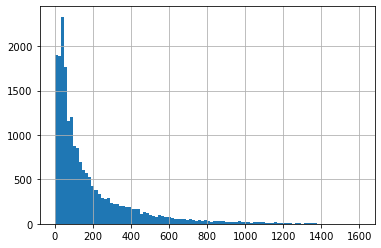

In [65]:
data['days_exposition'].hist(bins=100, range=(0, 1600))

In [66]:
days = data.query('days_exposition>=0')
display(f'Медиана: {days["days_exposition"].median()}')
display(f'Среднее: {days["days_exposition"].mean()}')

'Медиана: 95.0'

'Среднее: 180.56757285351065'

In [67]:
days['days_exposition'].describe()

count    20452.000000
mean       180.567573
std        219.472464
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Быстрыми продажами можно считать те, что были размещены менее 95 дней, долгими те, что были размещены болеее 230 дней 

In [68]:
def selling_speed(days_exposition):
    if days_exposition < 0:
        return 'Неизвестно'
    elif days_exposition < 95:
        return 'Быстрая'
    elif days_exposition > 230:
        return 'Долгая'
    else:
        return 'Средняя'

In [69]:
data['selling_speed'] = data['days_exposition'].apply(selling_speed)

#### Зависимость цены от различных параметров

##### Общая площадь

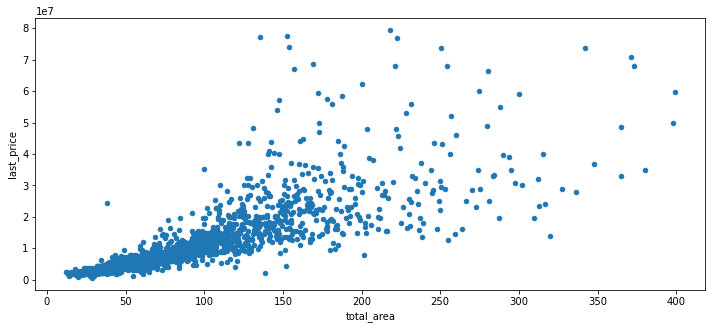

'Коэффициент корреляции равен 0.8157277009871785'

In [70]:
data_total_area = data.pivot_table(index = 'total_area', values = 'last_price')
data_total_area['total_area'] = data_total_area.index
data_total_area.plot(x='total_area', y='last_price', kind='scatter', figsize=(12, 5))
plt.show()
f'Коэффициент корреляции равен {data_total_area["total_area"].corr(data_total_area["last_price"])}'

В начале графика видно, что цена зависит от площади силно, но эта сильная зависимость пропадает, когда площадь начинает привышать 150 квадратных метров. Коэффициент корреляции Пирсона подтверждает, что данные довольно сильно взаимосвязаны между собой

##### Жилая площадь

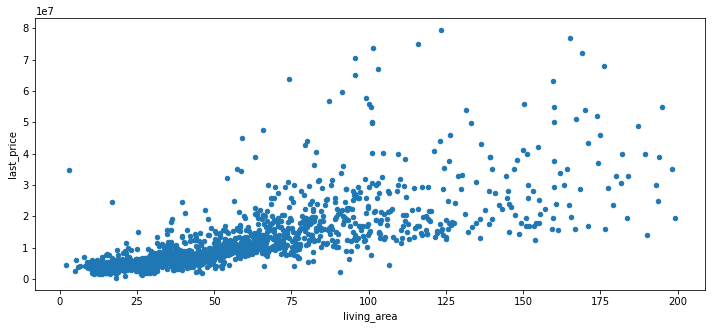

'Коэффициент корреляции равен 0.7602840852927233'

In [71]:
data_living_area = data.pivot_table(index = 'living_area', values = 'last_price')
data_living_area['living_area'] = data_living_area.index
data_living_area.plot(x='living_area', y='last_price', kind='scatter', figsize=(12, 5))
plt.show()
f'Коэффициент корреляции равен {data_living_area["living_area"].corr(data_living_area["last_price"])}'

С жилой площадью ситуация похожа на предыдущую, но также есть небольшие коллебания в начале графика. Из коэффициента корреляции видно, что зависимость немного меньше

##### Площадь кухни

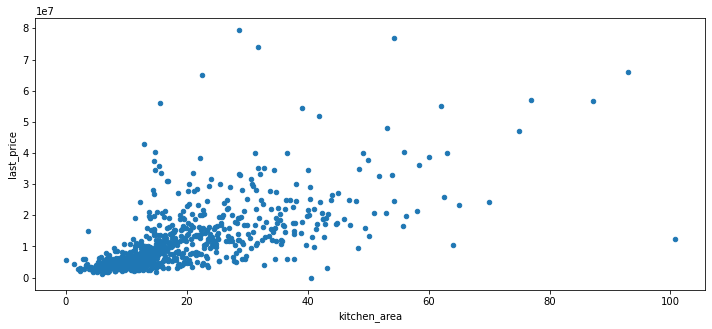

'Коэффициент корреляции равен 0.6792728015787839'

In [72]:
data_kitchen_area = data.pivot_table(index = 'kitchen_area', values = 'last_price')
data_kitchen_area['kitchen_area'] = data_kitchen_area.index
data_kitchen_area.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(12, 5))
plt.show()
f'Коэффициент корреляции равен {data_kitchen_area["kitchen_area"].corr(data_kitchen_area["last_price"])}'

На графике наблюдаются сильные колебания цены от площади кухни. Небольшая зависимость есть

##### Количество комнат

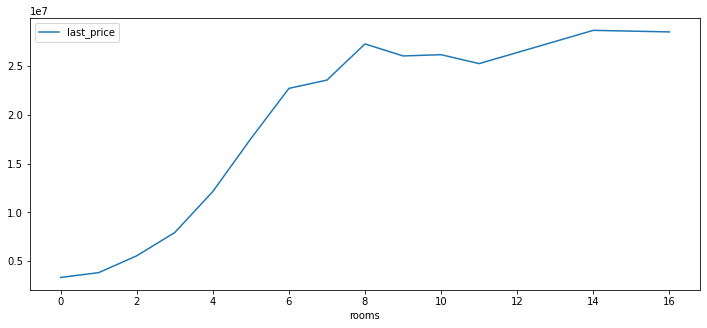

'Коэффициент корреляции равен 0.9030295733805512'

In [73]:
data_rooms = data.pivot_table(index = 'rooms', values = 'last_price')
data_rooms.plot(figsize=(12, 5))
plt.show()
data_rooms['rooms'] = data_rooms.index
f'Коэффициент корреляции равен {data_rooms["rooms"].corr(data_rooms["last_price"])}'

Очень хорошо видна зависимость: чем больше комнат, тем больше цена помещения. Коэффициент корреляции подтверждает данные графика

##### Тип этажа

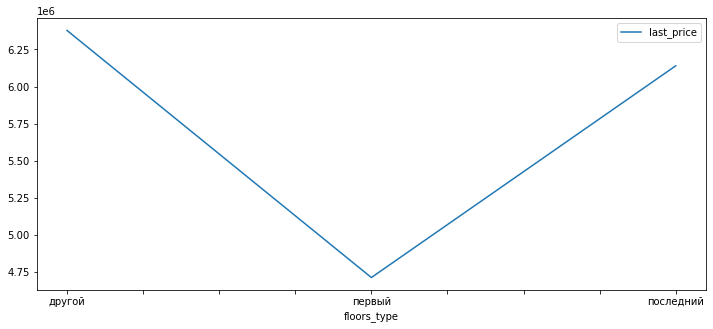

In [74]:
data.pivot_table(index = 'floors_type', values = 'last_price').plot(figsize=(12, 5))
plt.show()

Если квартира находится на первом этаже, цена значительно снижается, по сравнению с другими вариантами

##### День недели

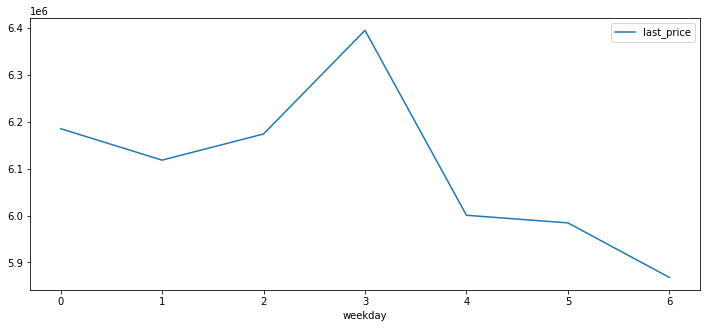

In [75]:
data.pivot_table(index = 'weekday', values = 'last_price').plot(figsize=(12, 5))
plt.show()

Интересно, что график похож на нормальное распределение. Помещения, продаваемые с середины недели стоят дороже, чем, продаваемые с начала или конца недели

##### Месяц

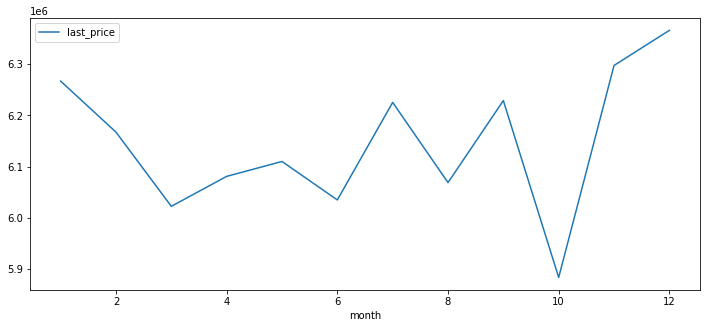

In [76]:
data.pivot_table(index = 'month', values = 'last_price').plot(figsize=(12, 5))
plt.show()

Цена скачит от месяца к месяцу

##### Год

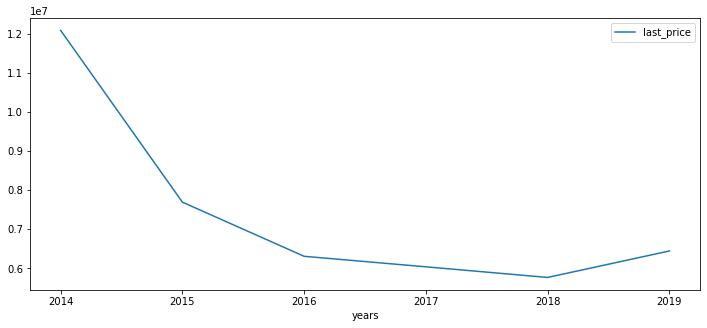

In [77]:
data.pivot_table(index = 'years', values = 'last_price').plot(figsize=(12, 5))
plt.show()

В 2014 году квартиры были значительно дороже, чем в последующие года, скорее всего на это повлиял кризис 2014 года. После 2014 года цена постепенно снижалась до 2018. И в 2019 произошел небольшой скачок цены наверх

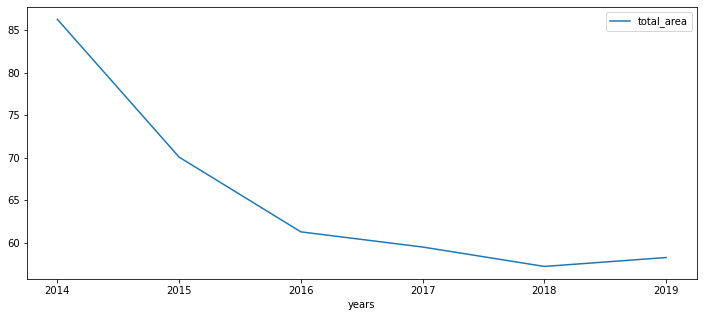

In [78]:
data.pivot_table(index = 'years', values = 'total_area').plot(figsize=(12, 5))
plt.show()

С 2014 года сильно упала площадь продаваемых квартир, следовательно упала и их цен. Кризис тут непричем (хотя он должен был внести свой вклад в цены квартир)

#### Цена за квадратный метр

In [79]:
data_price_one_meter = data.pivot_table(index='locality_name', values='price_one_square_meter', aggfunc=['count', 'mean'])
data_price_one_meter.columns = ['count', 'mean']
data_price_one_meter.sort_values(by='count', ascending=False)[:10].sort_values(by='mean', ascending = False)

,count,mean
locality_name,,
санкт-петербург,15640,113222.279376
пушкин,368,103100.890905
кудрово,472,95324.930544
поселок парголово,327,90175.913458
мурино,590,86087.512050
поселок шушары,440,78677.364217
колпино,338,75424.579098
гатчина,307,68746.146763
всеволожск,398,68654.473986


Самое дорогое жилье (цена за квадратные метр) в самом городе Санкт-Петербург, далее идут Пушкин и Кудрово. Самое дешевое жилье в Выборге, немного дороже во Всеволожске и Гатчине

#### Цена за киллометр

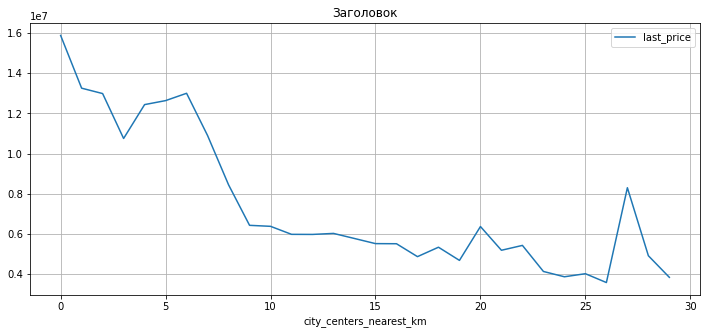

In [80]:
data_st = data.query('locality_name == "санкт-петербург"').pivot_table(index='city_centers_nearest_km', values='last_price')
data_st.plot(figsize=(12,5), grid = True, title = 'Заголовок');

Чем ближе помещение к центру Санкт-Петербурга, тем оно дороже. Есть скачки, но они незначительные.

### Общий вывод



#### В ходе исследование была проделана следующая работа:
- Проверены данные на пропуски, дубликаты и аномалии
- Изменены неккоректные типы данных
- Добавлены необходимые для анализа столбцы в таблицу
- Проведен исследовательский анализ всех необходимых данных
- Вычислена зависимость цены от различных параметров
- Составлена сводная таблица самых интересных районов Ленинградской области в зависимости от количества и цены помещений 

#### Были сделаны следующие выводы.
На цену помещения влияют многие параметры:
- Сильно влияют параметры площади, особенно если площадь небольшая. Чем больше площадь помещения, тем меньше ее значение влияет на общую стоимость это видно из следующих графиков и коэффициентоа корреляции.

Тип площади   | Коэффициент корреляции Пирсона
------------- | -----------------------
Полная площадь| 0.82
Жилая площадь | 0.76
Площадь кухни | 0.68

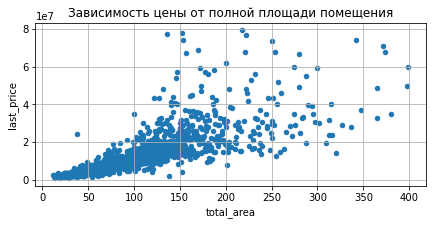

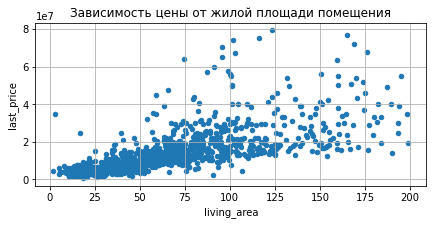

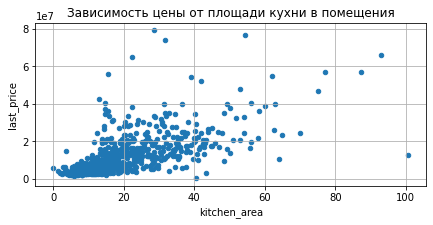

In [81]:
data_total_area.plot(x='total_area', y='last_price', kind='scatter', figsize=(7, 3), grid = True, 
                     title = 'Зависимость цены от полной площади помещения')
data_living_area.plot(x='living_area', y='last_price', kind='scatter', figsize=(7, 3), grid = True, 
                      title = 'Зависимость цены от жилой площади помещения')
data_kitchen_area.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(7, 3), grid = True, 
                       title = 'Зависимость цены от площади кухни в помещения')
plt.show()

- Сильно влияет на цену количество комнат в помещение. Убедится в этом можно на следующем графике. Это логично, так как количество комнат зависит от площади. Коэффициент корреляци равный 0.9 подтверждает данные графики

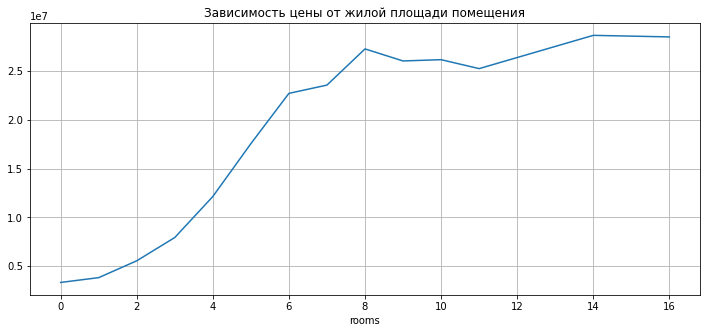

In [82]:
data_rooms['last_price'].plot(figsize=(12, 5), grid = True, title = 'Зависимость цены от жилой площади помещения')
plt.show()

- Квартиры на первом этаже сильно уступают в цене квартирам на других этажах. Это логично, так как квартыры на первом и последних этажах считаются самыми неудобными. Хотя данные также показывают, что квартиры на последнем этаже не уступаю в стоимости другим
- Цены на различные помещения сильно упали в цене с 2014 года. Хотя в 2019 году цена на них поднялась, она осталась все еще сильно меньше, чем в 2014 году. Это следует из факта, что такими же темпами падала площадь продаваемых помещений, что еще раз доказывает сильное влияние общей площади на цену.
- В квартирах, находящихся в Санкт-Петербурге цена за квадратный метр выше, чем в других регионах. Вот сводная таблица по самым популярным регионам Ленинградской области:

Населенный пункт  | Цена за квадратный метр
----------------- | -----------------------
Санкт-Петербург   | 113567.387578
Пушкин            | 103100.890905
Кудрово           | 95324.930544
поселок Парголово | 90175.913458
Мурино            | 86087.512050
поселок Шушары    | 78677.364217
Колпино           | 75424.579098
Гатчина           | 68746.146763
Всеволожск        | 68654.473986
Выборг            | 58141.909153

- Также стоимость помещения зависит от удаленности от центра, в центре инфраструктура и доступность многих объектов лучше, поэтому квартиры дороже:

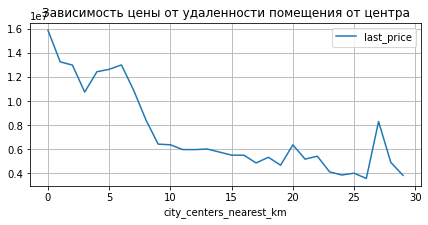

In [83]:
data_st.plot(figsize=(7,3), grid = True, title = 'Зависимость цены от удаленности помещения от центра')
plt.show()

Таким образом на стоимость квартиры сильнее всего влияет площадь и количество комнат, чуть хуже, но тоже сильно влияют параметры: населенный пункт и расстояние до центра. Другие параметры не рассматривались в данном проекте так подробно, как эти, поэтому нельзя сказать, что только 4 характеристики влияют на стоимость.